In [ ]:

!pip install -q torch torchvision transformers pillow tqdm faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 144.4 MB/s eta 0:00:00


In [ ]:
import os, random, glob, faiss, torch
import numpy as np
from tqdm import tqdm
from pathlib import Path
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

In [ ]:
ROOT_DIR   = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_3_sistema_recuperacion_texto_imagen/Caltech_Data/256_ObjectCategories"
SAMPLE_PCT = 0.30         # 30 %
EMB_DIM    = 512          # salida del modelo CLIP base
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
TOP_K      = 5            # imágenes que devolverá cada consulta

In [ ]:
# 1. Listar imágenes y muestrear 30 %
all_imgs = glob.glob(os.path.join(ROOT_DIR, "*", "*.jpg"))
random.shuffle(all_imgs)
sample_imgs = all_imgs[: int(len(all_imgs) * SAMPLE_PCT)]
print(f"Usando {len(sample_imgs):,} imágenes (~{SAMPLE_PCT:.0%})")

Usando 5,483 imágenes (~30%)


In [ ]:
# 2. Cargar modelo y processor
model     = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
# 3. Generar embeddings de imágenes
image_embs   = np.zeros((len(sample_imgs), EMB_DIM), dtype="float32")
image_paths  = []

for idx, img_path in enumerate(tqdm(sample_imgs, desc="Embeddings")):
    img = Image.open(img_path).convert("RGB")
    inputs = processor(images=img, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        emb = model.get_image_features(**inputs)
        emb = emb / emb.norm(p=2, dim=-1, keepdim=True)      # normalizar L2
    image_embs[idx] = emb.cpu().numpy()
    image_paths.append(img_path)

Embeddings:  85%|████████▍ | 4642/5483 [38:15<06:25,  2.18it/s]

In [ ]:
# 4. Construir índice FAISS (cosine ≈ inner-product sobre vectores normalizados)
index = faiss.IndexFlatIP(EMB_DIM)
index.add(image_embs)
print(f"Índice FAISS listo: {index.ntotal} vectores")

Índice FAISS listo: 5483 vectores


In [ ]:
# 5. Función de consulta texto → top-k imágenes
def search(query: str, k: int = TOP_K):
    inputs = processor(text=[query], return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        q_emb = model.get_text_features(**inputs)
        q_emb = q_emb / q_emb.norm(p=2, dim=-1, keepdim=True)
    q_emb = q_emb.cpu().numpy().astype("float32")

    scores, idxs = index.search(q_emb, k)      # (1 × k) distancias coseno
    hits = [(image_paths[i], float(scores[0][j])) for j, i in enumerate(idxs[0])]
    return hits

In [ ]:
# 6. Ejemplo de uso
for path, score in search("american flag"):
    print(f"{score:>.3f} → {Path(path).name}")

0.307 → 002_0019.jpg
0.299 → 002_0048.jpg
0.298 → 002_0089.jpg
0.298 → 002_0088.jpg
0.296 → 002_0023.jpg


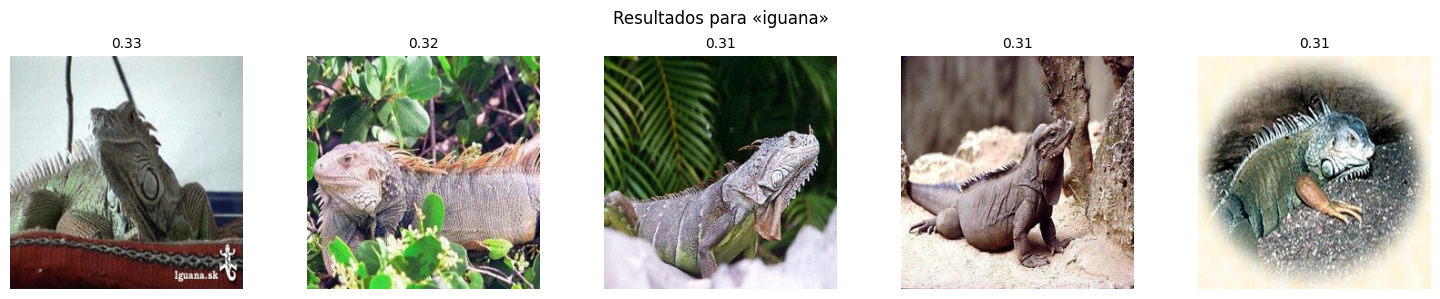

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

def show_results(query: str, k: int = TOP_K, size: int = 256):
    hits = search(query, k)
    fig, axes = plt.subplots(1, k, figsize=(k * 3, 3))
    for ax, (path, score) in zip(axes, hits):
        ax.imshow(Image.open(path).resize((size, size)))
        ax.set_title(f"{score:.2f}", fontsize=10)
        ax.axis("off")
    plt.suptitle(f"Resultados para «{query}»", fontsize=12)
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
show_results("iguana", k=5)

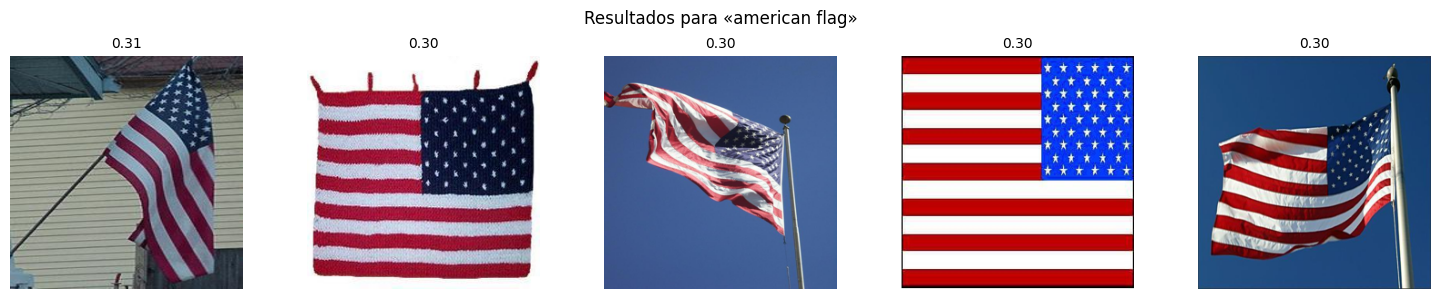

In [ ]:
# Ejemplo de uso
show_results("american flag", k=5)

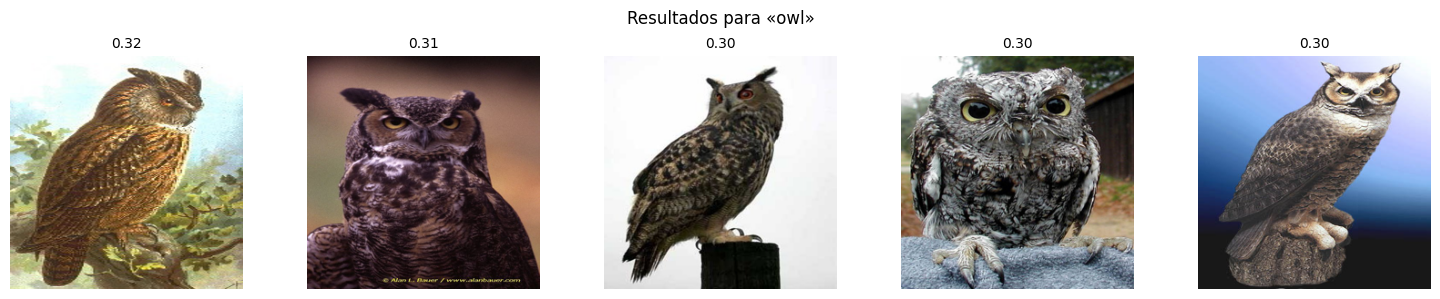

In [ ]:
show_results("owl", k=5)

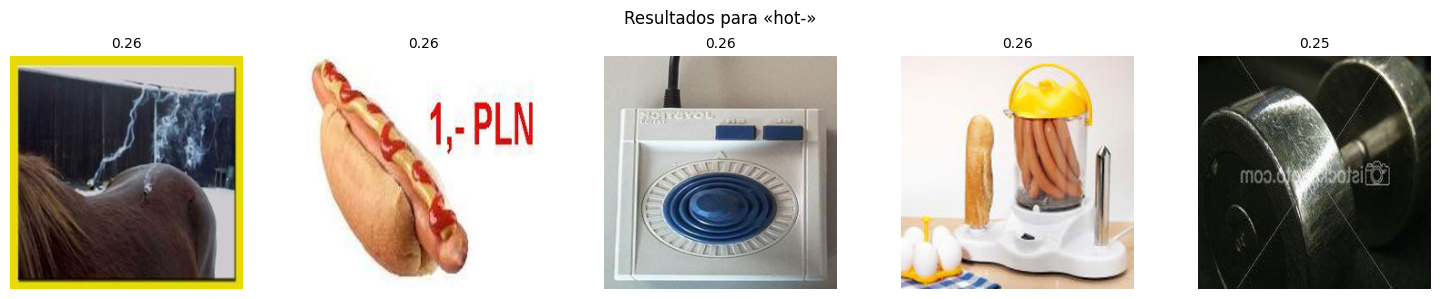

In [ ]:
show_results("hot-", k=5)
# se observa resultados ambiguos  sale imagenes en la data hay soo hay dos cagetorias con "hot-dog" y hot-air-balon" se observa  solos dos imangenes relacionadas las demas son de otras categorias se procedew a finetungin en experimento 2